# Clustering and spatial region annotation

This notebook runs clustering of cells by local neighborhood abundance vectors and then manual merging of clusters to comprise anatomic subregions and regions of the brain in the coronal sections datasets (aging, exercise, reprogramming), sagittal sections, and for the demyelination injury dataset (Androvic et al., 2023). Method adapted from Allen et al. (2023) Cell paper. This is an archival notebook.

**Inputs required:**
- `data/integrated_aging_coronal_clustered_registered.h5ad` - aging coronal sections AnnData object with rotated sections and cell type annotations (generated from `1B_rotational_alignment.ipynb`)
- `data/integrated_exercise_coronal_clustered_registered.h5ad` - exercise coronal sections AnnData object with rotated sections and cell type annotations (generated from `1B_rotational_alignment.ipynb`)
- `data/integrated_reprogramming_coronal_clustered_registered.h5ad` - reprogramming coronal sections AnnData object with rotated sections and cell type annotations (generated from `1B_rotational_alignment.ipynb`)
- `data/integrated_aging_sagittal_clustered_registered.h5ad` - aging sagittal sections AnnData object with rotated sections and cell type annotations (generated from `1B_rotational_alignment.ipynb`)
- `results/clocks/anndata/androvic_injuryMERFISH_spatialsmooth_spage.h5ad` - demyelination injury dataset with spatial aging clocks predictions (generated from `4A_application_to_interventions.ipynb`)

**Conda environment used**: `requirements/merfish.txt`

In [1]:
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import seaborn as sns
import anndata as ad
import os
from scipy.stats import pearsonr, spearmanr

In [2]:
# from Allen et al., 2023

# for each cell compute statistics of neighbors within radius
from sklearn.neighbors import KDTree
from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore
from tqdm import tqdm

def compute_neighborhood_stats(pos, labels, radius=100):
    # record labels as numbers
    labels_quant = LabelEncoder().fit_transform(labels)
    # for each cell, look up neighbors
    kdtree = KDTree(pos)
    nbors_idx, nbors_dist = kdtree.query_radius(pos, r=radius, return_distance=True)
    nbor_stats = np.zeros((pos.shape[0], len(np.unique(labels_quant))))

    for i in tqdm(range(pos.shape[0])):
        curr_nbors_idx = np.sort(nbors_idx[i][nbors_dist[i]>0])#[1:]
        curr_nbors_labels = labels_quant[curr_nbors_idx]
        for j in curr_nbors_labels:
            nbor_stats[i,j] += 1
    # zscore across each cluster
    for i in range(nbor_stats.shape[0]):
        nbor_stats[i,:] = zscore(nbor_stats[i,:])
    nbor_stats[np.isinf(nbor_stats)] = 0
    return nbor_stats

def plot_clust(A,clust_name, ax,s=0.1,key='kmeans'):
    pos = curr_adata.obsm['spatial']
    ax.scatter(pos[:,0], pos[:,1],s=1, c='gray')
    ax.scatter(pos[A.obs[key]==clust_name,0], pos[A.obs[key]==clust_name,1],s=s, c='r')
    ax.axis('off')
    ax.set_title(clust_name)

## Aging Coronal Dataset

In [3]:
fn = "integrated_aging_coronal_clustered_registered"
adata = sc.read_h5ad(f"data/{fn}.h5ad")

In [4]:
# Compute neighborhood stats (unlike in Allen et al., we do this for each sample by itself)
nbor_stats = np.zeros((adata.shape[0], len(np.unique(adata.obs.celltype))))

mids = np.sort(np.unique(adata.obs['mouse_id']))
for mid in mids:
    sub_adata = adata[adata.obs.mouse_id==mid].copy()
    nbor_stats[adata.obs.mouse_id==mid,:] = compute_neighborhood_stats(sub_adata.obsm['spatial'],
                                                                       sub_adata.obs.celltype, radius=100)

100%|██████████| 97015/97015 [00:25<00:00, 3787.64it/s]


In [5]:
# Clustering

# impute nans
nbor_stats[np.isnan(nbor_stats)] = 0

# do PCA
from sklearn.decomposition import PCA
xform = PCA(random_state=50).fit_transform(nbor_stats)

# encode labebls
labels_quant = LabelEncoder().fit_transform(adata.obs.celltype)

# K- Means
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=25, random_state=444).fit_predict(xform)
adata.obs['kmeans'] = kmeans

/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [7]:
# save intermediate
adata.write_h5ad(f"data/{fn}_kmeans.h5ad")

In [7]:
# load intermediate
adata=sc.read_h5ad(f"data/{fn}_kmeans.h5ad")

3.8


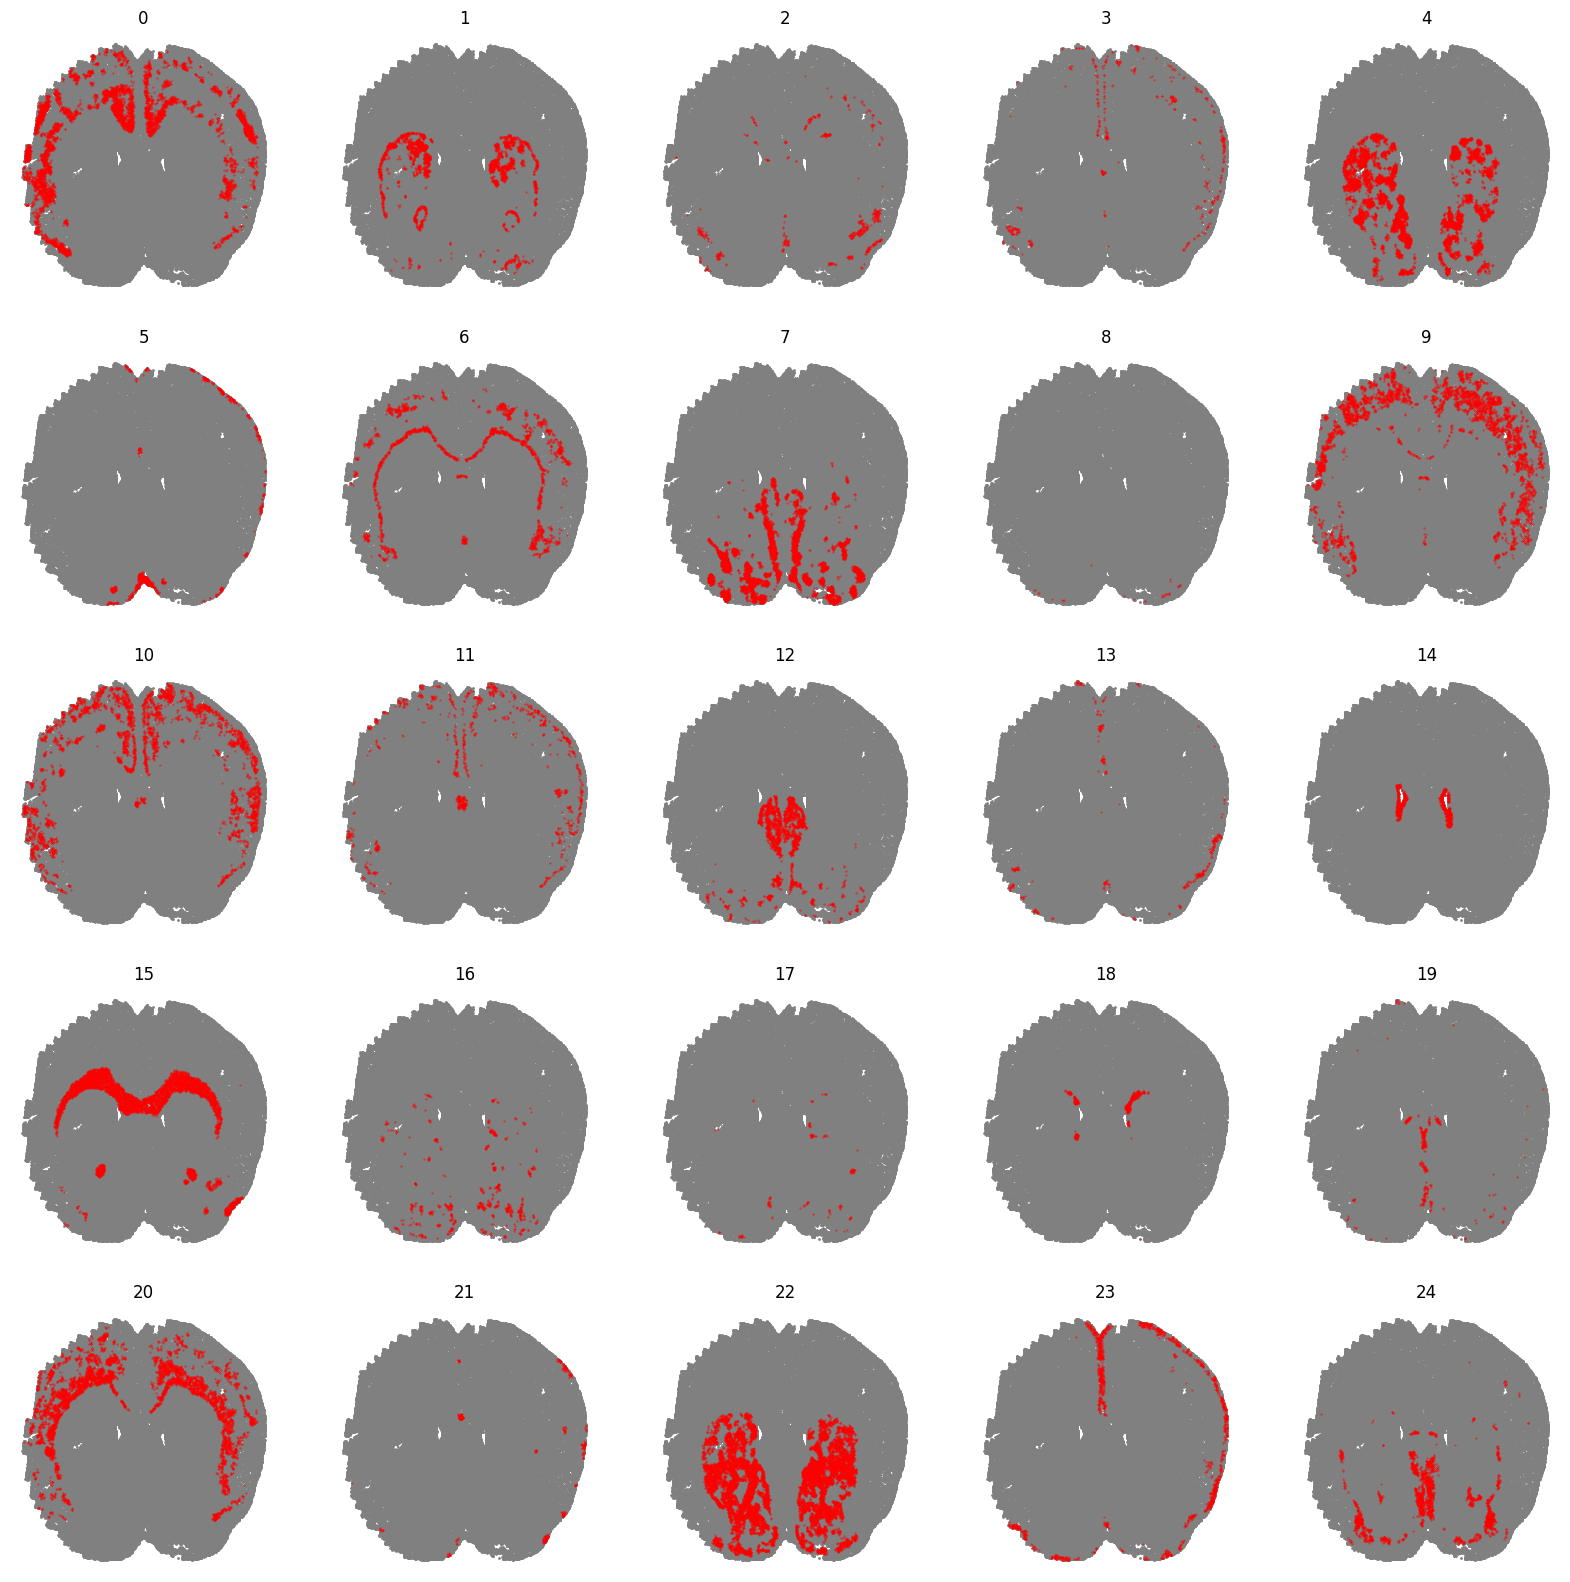

32.6


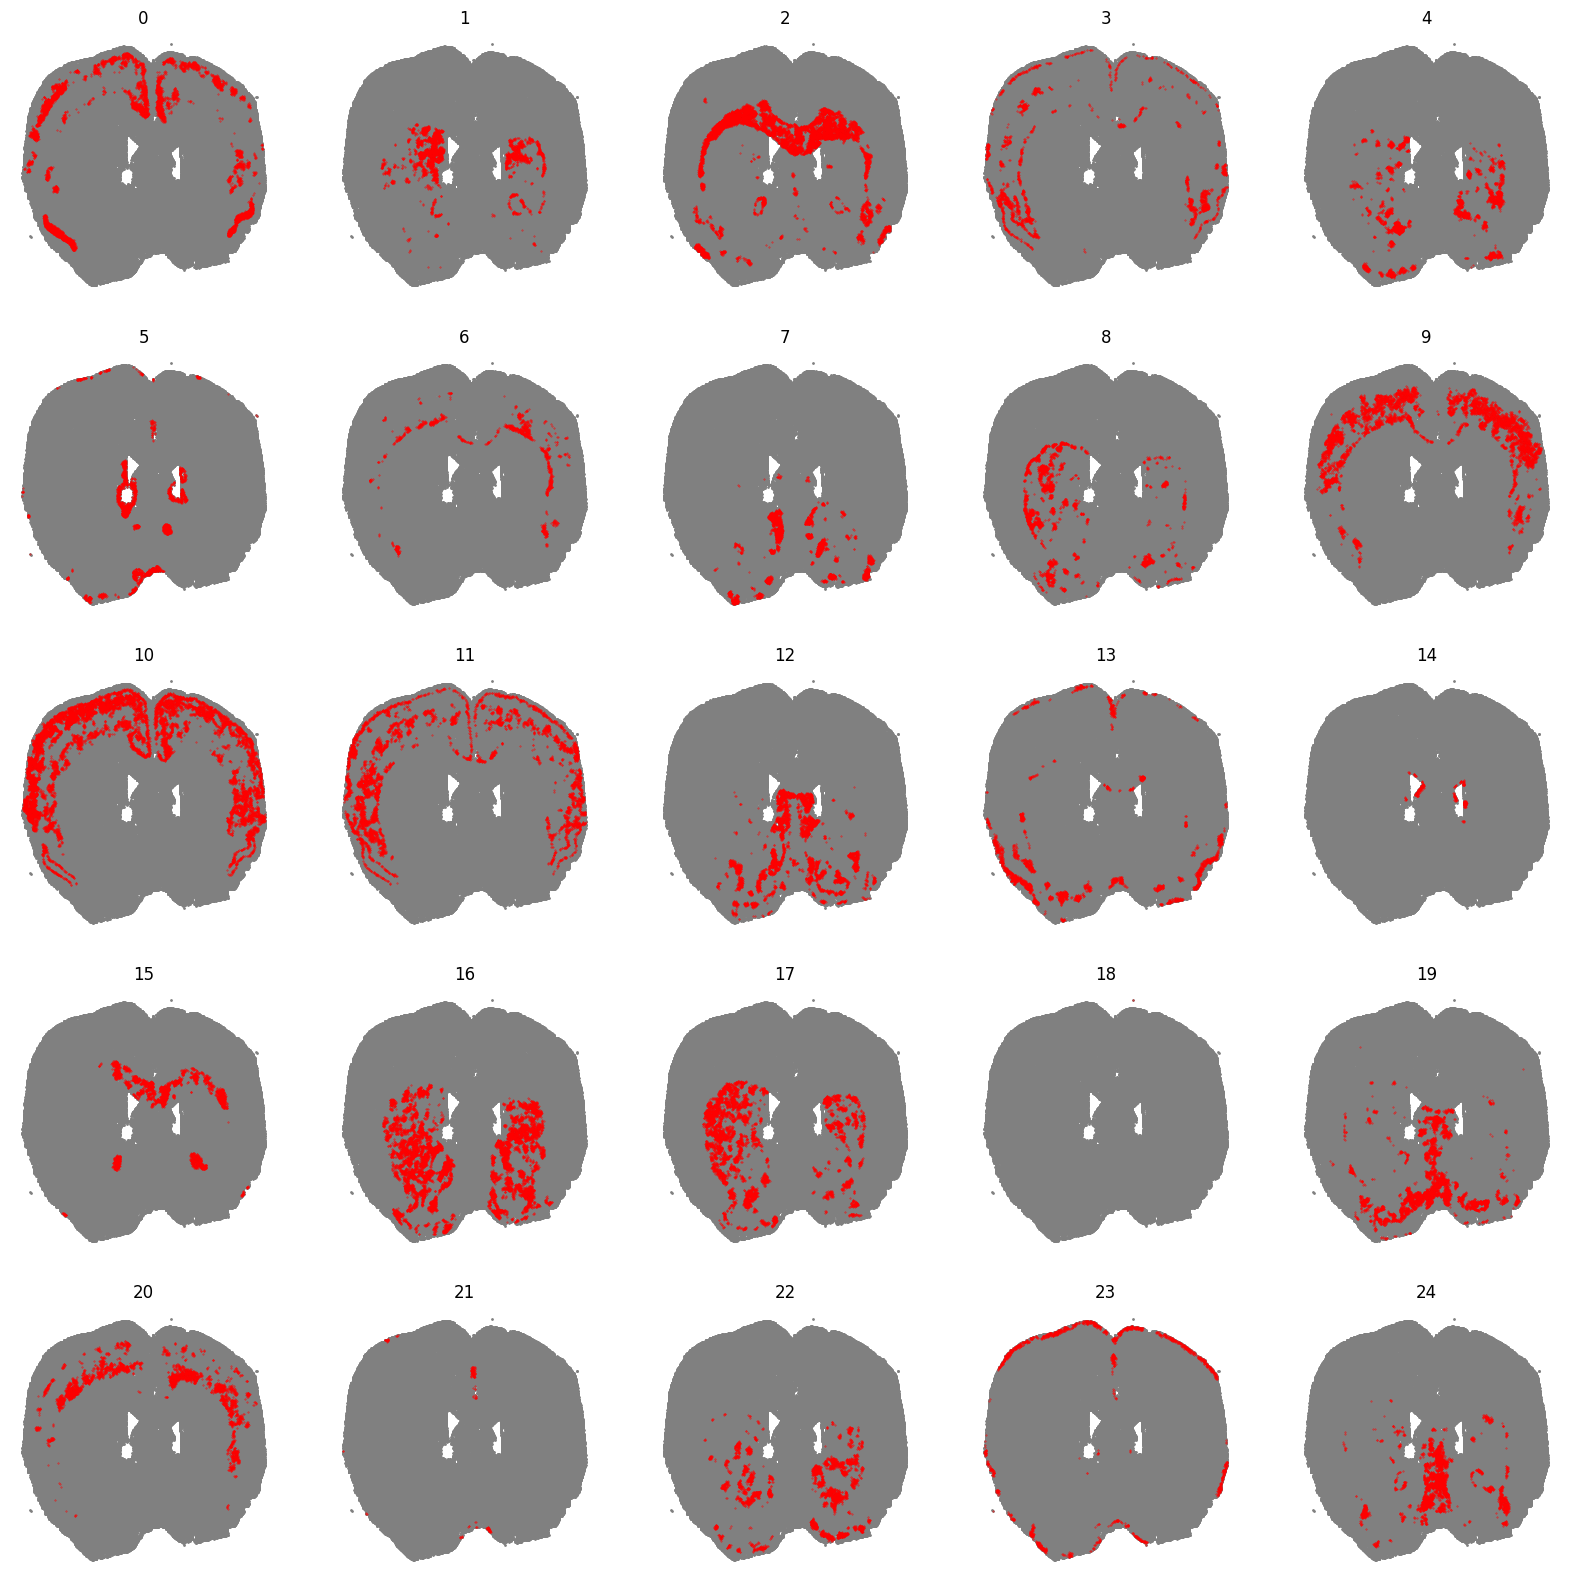

19.8


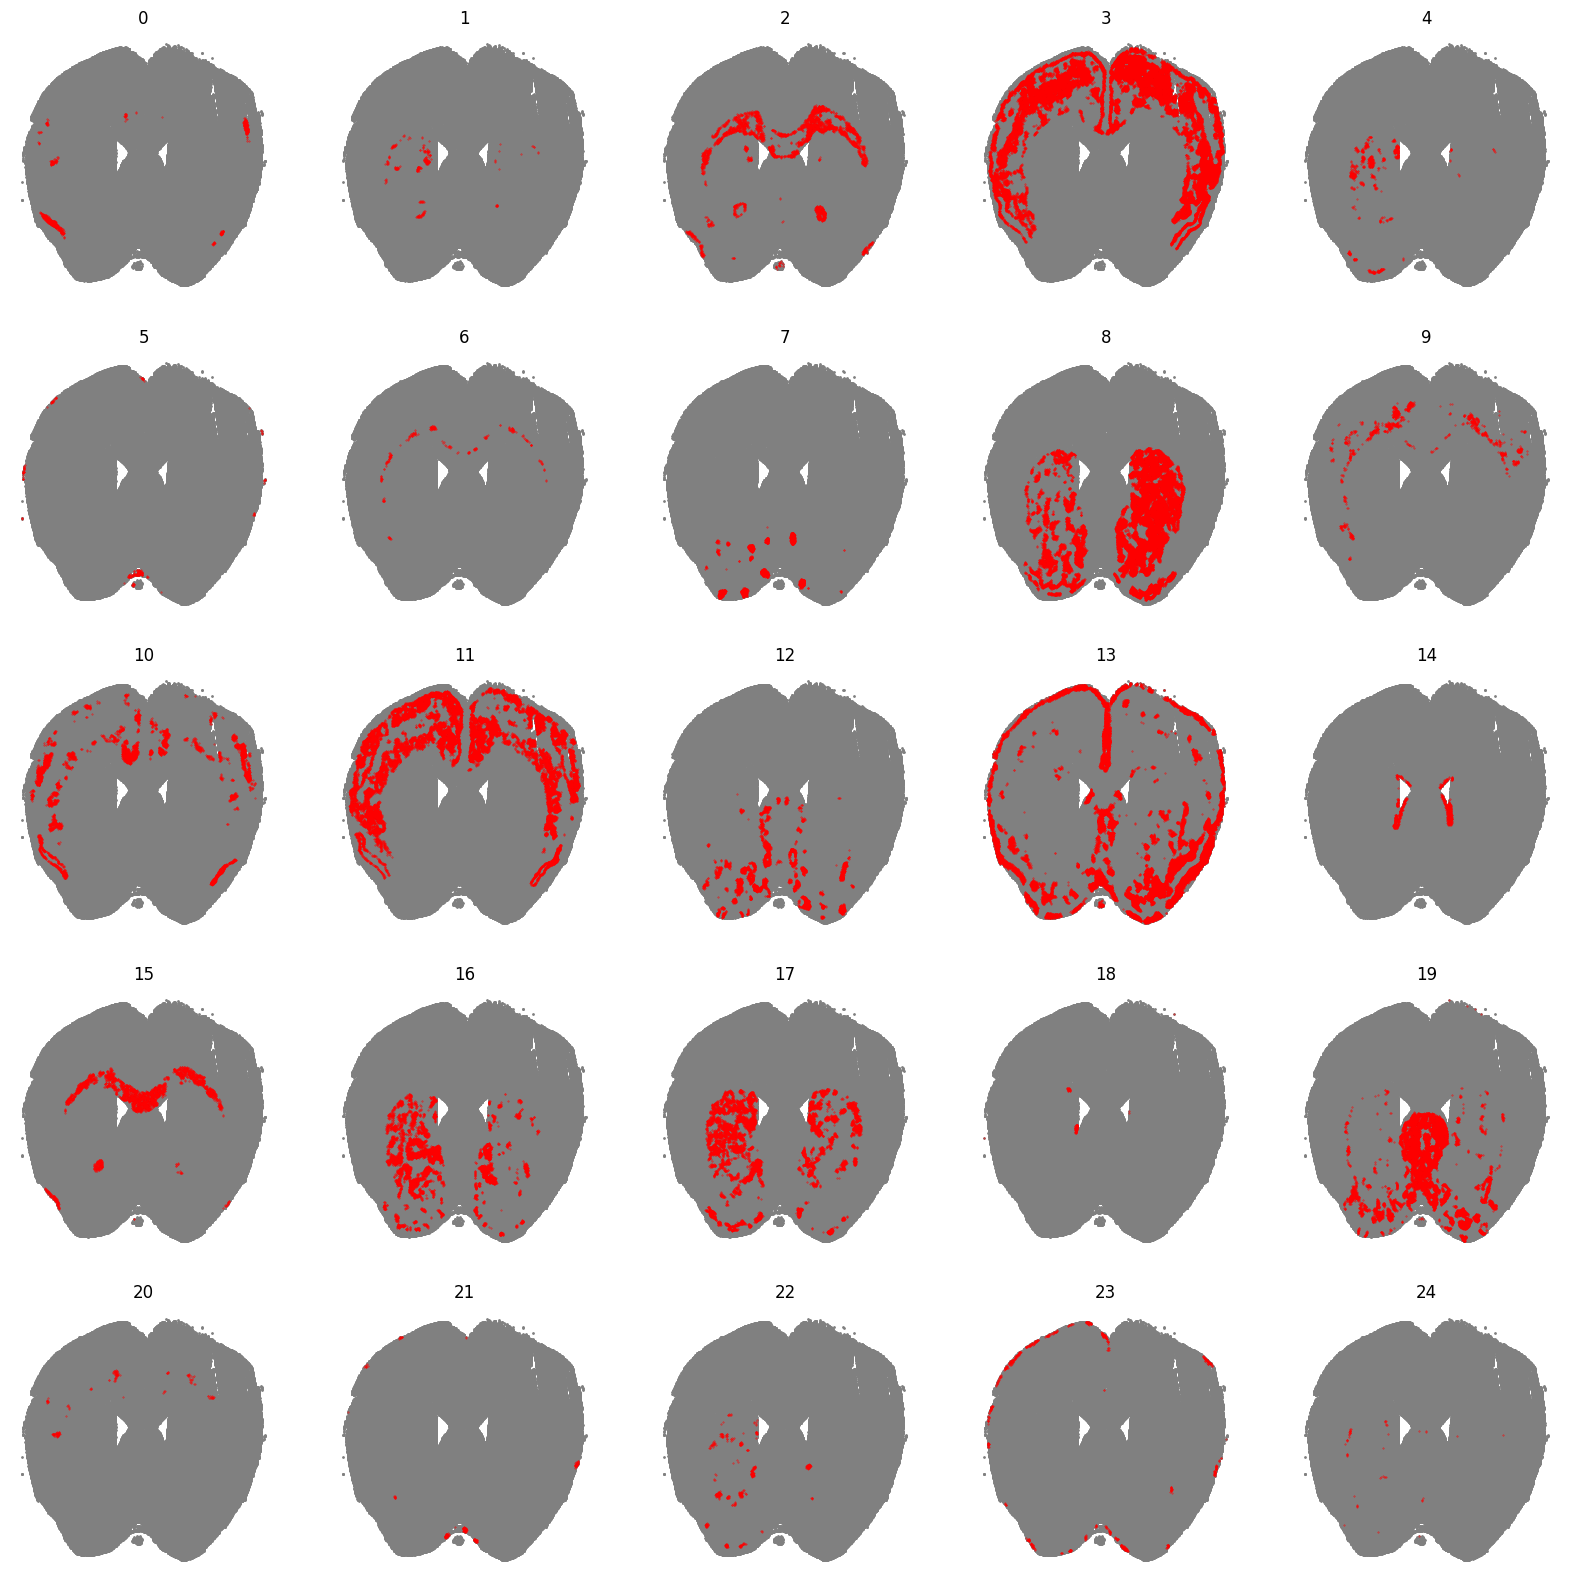

In [8]:
# Plot clusters

example_ids = ["1","97","80"]

for example in example_ids:
    curr_adata = adata[adata.obs.mouse_id==example].copy()
    print(curr_adata.obs.age[0])
    
    plt.figure(figsize=(20,20))
    for i in range(curr_adata.obs.kmeans.max()+1):
        ax = plt.subplot(5,5,i+1)
        plot_clust(curr_adata,i,ax,key='kmeans')
    plt.show()

In [12]:
# manual region annotations

spatial_clust_annots_coarser = {
    0: 'CTX_L2/3',
 1: 'STR_CP/ACB',
 2: 'CC/ACO',
 3: 'CTX_L2/3',
 4: 'STR_CP/ACB',
 5: 'CTX_L1/MEN',
 6: 'CTX_L4/5/6',
 7: 'STR_LS/NDB',
 8: 'STR_CP/ACB',
 9: 'CTX_L4/5/6',
 10: 'CTX_L2/3',
 11: 'CTX_L2/3',
 12: 'STR_LS/NDB',
 13: 'CTX_L1/MEN',
 14: 'VEN',
 15: 'CC/ACO',
 16: 'STR_CP/ACB',
 17: 'STR_CP/ACB',
 18: 'VEN',
 19: 'STR_LS/NDB',
 20: 'CTX_L4/5/6',
 21: 'CTX_L1/MEN',
 22: 'STR_CP/ACB',
 23: 'CTX_L1/MEN',
 24: 'STR_LS/NDB',
}

In [13]:
# map annotations 

adata.obs['region'] = [spatial_clust_annots_coarser[i] for i in adata.obs.kmeans]

3.8


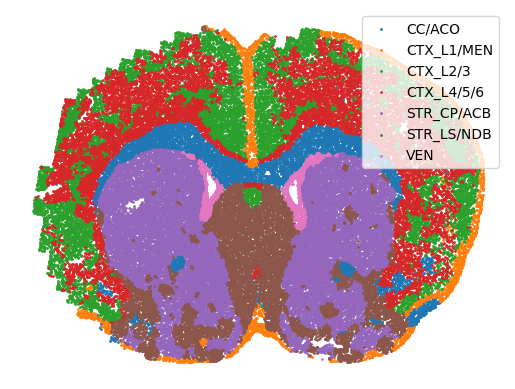

32.6


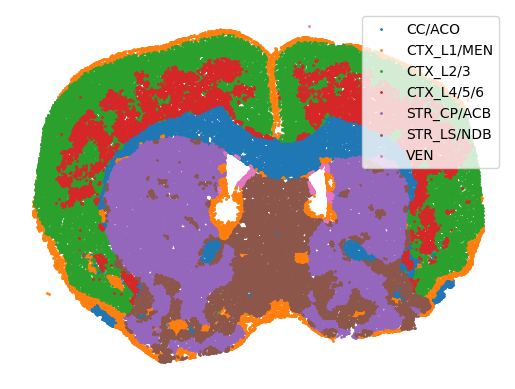

In [15]:
# visualize examples of regions spatially

example_ids = ["1", "97"]

for example in example_ids:
    curr_adata = adata[adata.obs.mouse_id==example].copy()
    print(curr_adata.obs.age[0])
    pos = curr_adata.obsm['spatial']
    for region in np.unique(curr_adata.obs.region):
        plt.scatter(pos[curr_adata.obs.region==region,0],
                    pos[curr_adata.obs.region==region,1],
                    s=1, label=region)
    plt.legend()
    plt.axis('off')
    plt.show()

In [ ]:
# visualize all region annotations spatially

fig, axarr = plt.subplots(4, 6, sharex=False, sharey=False, figsize=(20,9))
mids = np.sort(np.unique(adata.obs['mouse_id']))
for i in range(4):
    for j in range(6):
        if (i*6+j) < len(mids):
            mid= mids[i*6+j]
            sub_adata = adata[adata.obs['mouse_id']==mid].copy()
            sc.pl.embedding(sub_adata, 'spatial', color="region", size=10, show=False,
                            title=mid, ax=axarr[i,j], vmin=-10, vmax=10)
plt.suptitle("Aligned slices with Regions")
plt.tight_layout()
plt.show()

In [22]:
# save regioned dataset

adata.write_h5ad("data/integrated_aging_coronal_celltyped_regioned.h5ad")

In [3]:
# transfer annotations to raw data

adata = sc.read_h5ad("data/integrated_aging_coronal_celltyped_regioned.h5ad")
raw_adata = sc.read_h5ad("data/integrated_aging_coronal_clustered_raw.h5ad")

# add labels
raw_adata.obsm['spatial'] = np.array(adata.obsm['spatial'].copy())
raw_adata.obs['kmeans'] = np.array(adata.obs['kmeans'].copy())
raw_adata.obs['region'] = np.array(adata.obs['region'].copy())

# save updated raw dataset
raw_adata.write_h5ad("data/integrated_aging_coronal_celltyped_regioned_raw.h5ad")

## Exercise Coronal Dataset

In [3]:
fn = "integrated_exercise_coronal_clustered_registered"
adata = sc.read_h5ad(f"data/{fn}.h5ad")

In [4]:
# Compute neighborhood stats (unlike in Allen et al., we do this for each sample by itself)
nbor_stats = np.zeros((adata.shape[0], len(np.unique(adata.obs.celltype))))

mids = np.sort(np.unique(adata.obs['mouse_id']))
for mid in mids:
    sub_adata = adata[adata.obs.mouse_id==mid].copy()
    nbor_stats[adata.obs.mouse_id==mid,:] = compute_neighborhood_stats(sub_adata.obsm['spatial'],
                                                                       sub_adata.obs.celltype, radius=100)

100%|██████████| 94939/94939 [00:06<00:00, 15121.70it/s]


In [5]:
# Clustering

# impute nans
nbor_stats[np.isnan(nbor_stats)] = 0

# do PCA
from sklearn.decomposition import PCA
xform = PCA(random_state=50).fit_transform(nbor_stats)

# encode labebls
labels_quant = LabelEncoder().fit_transform(adata.obs.celltype)

# K- Means
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=25, random_state=444).fit_predict(xform)
adata.obs['kmeans'] = kmeans

/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [6]:
# save intermediate
adata.write_h5ad(f"data/{fn}_kmeans.h5ad")

In [7]:
# load intermediate
adata=sc.read_h5ad(f"data/{fn}_kmeans.h5ad")

In [ ]:
# Plot clusters

example_ids = ["OE4", "YC1"]

for example in example_ids:
    curr_adata = adata[adata.obs.mouse_id==example].copy()
    print(curr_adata.obs.age[0])
    
    plt.figure(figsize=(20,20))
    for i in range(curr_adata.obs.kmeans.max()+1):
        ax = plt.subplot(5,5,i+1)
        plot_clust(curr_adata,i,ax,key='kmeans')
    plt.show()

In [9]:
# manual region annotations

spatial_clust_annots_coarser = {
    0: 'VEN',
 1: 'CTX_L2/3',
 2: 'STR_CP/ACB',
 3: 'CTX_L2/3',
 4: 'CTX_L4/5/6',
 5: 'STR_CP/ACB',
 6: 'STR_LS/NDB',
 7: 'CTX_L1/MEN',
 8: 'CTX_L4/5/6',
 9: 'CTX_L1/MEN',
 10: 'STR_CP/ACB',
 11: 'CTX_L4/5/6',
 12: 'STR_LS/NDB',
 13: 'STR_CP/ACB',
 14: 'CTX_L2/3',
 15: 'STR_CP/ACB',
 16: 'STR_LS/NDB',
 17: 'CC/ACO',
 18: 'CTX_L1/MEN',
 19: 'CTX_L2/3',
 20: 'STR_LS/NDB',
 21: 'VEN',
 22: 'CTX_L1/MEN',
 23: 'CC/ACO',
 24: 'STR_CP/ACB',
}

In [10]:
# map annotations 

adata.obs['region'] = [spatial_clust_annots_coarser[i] for i in adata.obs.kmeans]

In [ ]:
# visualize examples of regions spatially

example_ids = ["OE4", "YC1"]

for example in example_ids:
    curr_adata = adata[adata.obs.mouse_id==example].copy()
    print(curr_adata.obs.age[0])
    pos = curr_adata.obsm['spatial']
    for region in np.unique(curr_adata.obs.region):
        plt.scatter(pos[curr_adata.obs.region==region,0],
                    pos[curr_adata.obs.region==region,1],
                    s=1, label=region)
    plt.legend()
    plt.axis('off')
    plt.show()

In [ ]:
# visualize all region annotations spatially

fig, axarr = plt.subplots(4, 6, sharex=False, sharey=False, figsize=(20,9))
mids = np.sort(np.unique(adata.obs['mouse_id']))
for i in range(4):
    for j in range(6):
        if (i*6+j) < len(mids):
            mid= mids[i*6+j]
            sub_adata = adata[adata.obs['mouse_id']==mid].copy()
            sc.pl.embedding(sub_adata, 'spatial', color="region", size=10, show=False,
                            title=mid, ax=axarr[i,j], vmin=-10, vmax=10)
plt.suptitle("Aligned slices with Regions")
plt.tight_layout()
plt.show()

In [13]:
# save regioned dataset

adata.write_h5ad("data/integrated_exercise_coronal_celltyped_regioned.h5ad")

In [3]:
# transfer annotations to raw data

adata = sc.read_h5ad("data/integrated_exercise_coronal_celltyped_regioned.h5ad")
raw_adata = sc.read_h5ad("data/integrated_exercise_coronal_clustered_raw.h5ad")

# add labels
raw_adata.obsm['spatial'] = np.array(adata.obsm['spatial'].copy())
raw_adata.obs['kmeans'] = np.array(adata.obs['kmeans'].copy())
raw_adata.obs['region'] = np.array(adata.obs['region'].copy())

# save updated raw dataset
raw_adata.write_h5ad("data/integrated_exercise_coronal_celltyped_regioned_raw.h5ad")

## Reprogramming Coronal Dataset

In [3]:
fn = "integrated_reprogramming_coronal_clustered_registered"
adata = sc.read_h5ad(f"data/{fn}.h5ad")

In [4]:
# Compute neighborhood stats (unlike in Allen et al., we do this for each sample by itself)
nbor_stats = np.zeros((adata.shape[0], len(np.unique(adata.obs.celltype))))

mids = np.sort(np.unique(adata.obs['mouse_id']))
for mid in mids:
    sub_adata = adata[adata.obs.mouse_id==mid].copy()
    nbor_stats[adata.obs.mouse_id==mid,:] = compute_neighborhood_stats(sub_adata.obsm['spatial'],
                                                                       sub_adata.obs.celltype, radius=100)

100%|██████████| 101240/101240 [00:08<00:00, 12429.68it/s]


In [5]:
# Clustering

# impute nans
nbor_stats[np.isnan(nbor_stats)] = 0

# do PCA
from sklearn.decomposition import PCA
xform = PCA(random_state=50).fit_transform(nbor_stats)

# encode labebls
labels_quant = LabelEncoder().fit_transform(adata.obs.celltype)

# K- Means
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=25, random_state=444).fit_predict(xform)
adata.obs['kmeans'] = kmeans

/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [6]:
# save intermediate
adata.write_h5ad(f"data/{fn}_kmeans.h5ad")

In [7]:
# load intermediate
adata=sc.read_h5ad(f"data/{fn}_kmeans.h5ad")

In [ ]:
# Plot clusters

example_ids = np.unique(adata.obs.mouse_id)#["OT902", "YC1990", "OC1083"]

for example in example_ids:
    curr_adata = adata[adata.obs.mouse_id==example].copy()
    print(curr_adata.obs.age[0])
    
    plt.figure(figsize=(20,20))
    for i in range(curr_adata.obs.kmeans.max()+1):
        ax = plt.subplot(5,5,i+1)
        plot_clust(curr_adata,i,ax,key='kmeans')
    plt.show()

In [14]:
# manual region annotations

spatial_clust_annots_coarser = {
    0: 'CTX_L2/3',
 1: 'STR_CP/ACB',
 2: 'CTX_L4/5/6',
 3: 'CTX_L4/5/6',
 4: 'STR_CP/ACB',
 5: 'CTX_L1/MEN',
 6: 'CTX_L2/3',
 7: 'CC/ACO',
 8: 'STR_CP/ACB',
 9: 'STR_LS/NDB',
 10: 'CC/ACO',
 11: 'STR_LS/NDB',
 12: 'STR_CP/ACB', # localized to one section only...
 13: 'CC/ACO',
 14: 'CTX_L1/MEN',
 15: 'STR_CP/ACB',
 16: 'STR_CP/ACB',
 17: 'STR_LS/NDB',
 18: 'VEN',
 19: 'STR_CP/ACB',
 20: 'STR_LS/NDB',
 21: 'CTX_L4/5/6',
 22: 'CTX_L1/MEN',
 23: 'CTX_L2/3',
 24: 'CTX_L2/3',
}

In [15]:
# map annotations 

adata.obs['region'] = [spatial_clust_annots_coarser[i] for i in adata.obs.kmeans]

In [ ]:
# visualize all region annotations spatially

fig, axarr = plt.subplots(4, 6, sharex=False, sharey=False, figsize=(20,9))
mids = np.sort(np.unique(adata.obs['mouse_id']))
for i in range(4):
    for j in range(6):
        if (i*6+j) < len(mids):
            mid= mids[i*6+j]
            sub_adata = adata[adata.obs['mouse_id']==mid].copy()
            sc.pl.embedding(sub_adata, 'spatial', color="region", size=10, show=False,
                            title=mid, ax=axarr[i,j], vmin=-10, vmax=10)
plt.suptitle("Aligned slices with Regions")
plt.tight_layout()
plt.show()

In [17]:
# save regioned dataset

adata.write_h5ad("data/integrated_reprogramming_coronal_celltyped_regioned.h5ad")

In [3]:
# transfer annotations to raw data

adata = sc.read_h5ad("data/integrated_reprogramming_coronal_celltyped_regioned.h5ad")
raw_adata = sc.read_h5ad("data/integrated_reprogramming_coronal_clustered_raw.h5ad")

# add labels
raw_adata.obsm['spatial'] = np.array(adata.obsm['spatial'].copy())
raw_adata.obs['kmeans'] = np.array(adata.obs['kmeans'].copy())
raw_adata.obs['region'] = np.array(adata.obs['region'].copy())

# save updated raw dataset
raw_adata.write_h5ad("data/integrated_reprogramming_coronal_celltyped_regioned_raw.h5ad")

# Post Clock Prediction Segmentations

These provide region segmentation labels on the AnnData objects after making spatial clock predictions. Will need outputs from later notebooks.

## Sagittal Sections

In [5]:
fn = "integrated_aging_sagittal_clustered_registered"
adata = sc.read_h5ad(f"data/{fn}.h5ad")

In [ ]:
# Compute neighborhood stats (unlike in Allen et al., we do this for each sample by itself)
nbor_stats = np.zeros((adata.shape[0], len(np.unique(adata.obs.celltype))))

mids = np.sort(np.unique(adata.obs['mouse_id']))
for mid in mids:
    sub_adata = adata[adata.obs.mouse_id==mid].copy()
    nbor_stats[adata.obs.mouse_id==mid,:] = compute_neighborhood_stats(sub_adata.obsm['spatial'],
                                                                       sub_adata.obs.celltype, radius=100)

In [ ]:
# Clustering

# impute nans
nbor_stats[np.isnan(nbor_stats)] = 0

# do PCA
from sklearn.decomposition import PCA
xform = PCA(random_state=50).fit_transform(nbor_stats)

# encode labebls
labels_quant = LabelEncoder().fit_transform(adata.obs.celltype)

# K- Means
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=25, random_state=444).fit_predict(xform)
adata.obs['kmeans'] = kmeans

In [6]:
# save intermediate
adata.write_h5ad(f"data/{fn}_kmeans.h5ad")

In [6]:
# load intermediate
adata=sc.read_h5ad(f"data/{fn}_kmeans.h5ad")

In [ ]:
# Plot clusters

example_ids = np.unique(adata.obs.mouse_id)#["OT902", "YC1990", "OC1083"]

for example in example_ids:
    curr_adata = adata[adata.obs.mouse_id==example].copy()
    print(curr_adata.obs.age[0])
    
    plt.figure(figsize=(20,20))
    for i in range(curr_adata.obs.kmeans.max()+1):
        ax = plt.subplot(5,5,i+1)
        plot_clust(curr_adata,i,ax,key='kmeans')
    plt.show()

In [8]:
# manual region annotations

spatial_clust_annots_coarser = {
    0: 'Thalamus',
 1: 'OB',
 2: 'CTX',
 3: 'STR',
 4: 'Fiber_Tracts',
 5: 'CTX',
 6: 'CTX',
 7: 'VEN',
 8: 'Thalamus',
 9: 'OB/CB',
 10: 'STR',
 11: 'CTX',
 12: 'Thalamus', 
 13: 'OB/CB',
 14: 'STR',
 15: 'VEN',
 16: 'OB/CB',
 17: 'CTX',
 18: 'Midbrain',
 19: 'Thalamus',
 20: 'STR',
 21: 'OB/CB',
 22: 'Midbrain',
 23: 'Thalamus',
 24: 'Fiber_Tracts',
}

In [10]:
# map annotations 

adata.obs['region'] = [spatial_clust_annots_coarser[i] for i in adata.obs.kmeans]

In [11]:
# split cerebellum by x units
fine_regions = adata.obs.region.copy().astype(str)

fine_regions[(fine_regions=="CTX")&(adata.obsm["spatial"][:,0]>4200)] = "CB"
fine_regions[(fine_regions=="OB/CB")&(adata.obsm["spatial"][:,0]>4200)] = "CB"
fine_regions[(fine_regions=="OB/CB")&(adata.obsm["spatial"][:,0]<-3000)] = "OB"
fine_regions[fine_regions=="OB/CB"] = "Thalamus"

adata.obs["region"] = fine_regions.astype('category')

In [12]:
# save regioned dataset

adata.write_h5ad("data/integrated_sagittal_celltyped_regioned.h5ad")

In [13]:
# transfer annotations to raw data

adata = sc.read_h5ad("data/integrated_sagittal_celltyped_regioned.h5ad")
raw_adata = sc.read_h5ad("data/integrated_aging_sagittal_clustered_registered_raw.h5ad")

# add labels
raw_adata.obsm['spatial'] = np.array(adata.obsm['spatial'].copy())
raw_adata.obs['kmeans'] = np.array(adata.obs['kmeans'].copy())
raw_adata.obs['region'] = np.array(adata.obs['region'].copy())

# save updated raw dataset
raw_adata.write_h5ad("data/integrated_aging_sagittal_clustered_registered_raw.h5ad")

In [14]:
# transfer annotations to predictions data

adata = sc.read_h5ad("data/integrated_sagittal_celltyped_regioned.h5ad")
raw_adata = sc.read_h5ad("results/clocks/anndata/sagittal_spatialsmooth.h5ad")

# add labels
raw_adata.obs['kmeans'] = np.array(adata.obs['kmeans'].copy())
raw_adata.obs['region'] = np.array(adata.obs['region'].copy())

# save updated raw dataset
raw_adata.write_h5ad("results/clocks/anndata/sagittal_spatialsmooth.h5ad")

## Androvic et al. (2023)

In [3]:
fn = "results/clocks/anndata/androvic_injuryMERFISH_spatialsmooth_spage"
adata = sc.read_h5ad(f"{fn}.h5ad")

In [4]:
# Compute neighborhood stats (unlike in Allen et al., we do this for each sample by itself)
nbor_stats = np.zeros((adata.shape[0], len(np.unique(adata.obs.celltype))))

mids = np.sort(np.unique(adata.obs['mouse_id']))
for mid in mids:
    sub_adata = adata[adata.obs.mouse_id==mid].copy()
    nbor_stats[adata.obs.mouse_id==mid,:] = compute_neighborhood_stats(sub_adata.obsm['spatial'],
                                                                       sub_adata.obs.celltype, radius=100)

100%|██████████| 108797/108797 [00:06<00:00, 16584.36it/s]


In [5]:
# Clustering

# impute nans
nbor_stats[np.isnan(nbor_stats)] = 0

# do PCA
from sklearn.decomposition import PCA
xform = PCA(random_state=50).fit_transform(nbor_stats)

# encode labels
labels_quant = LabelEncoder().fit_transform(adata.obs.celltype)

# K- Means
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=25, random_state=444).fit_predict(xform)
adata.obs['kmeans'] = kmeans

/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


3.5


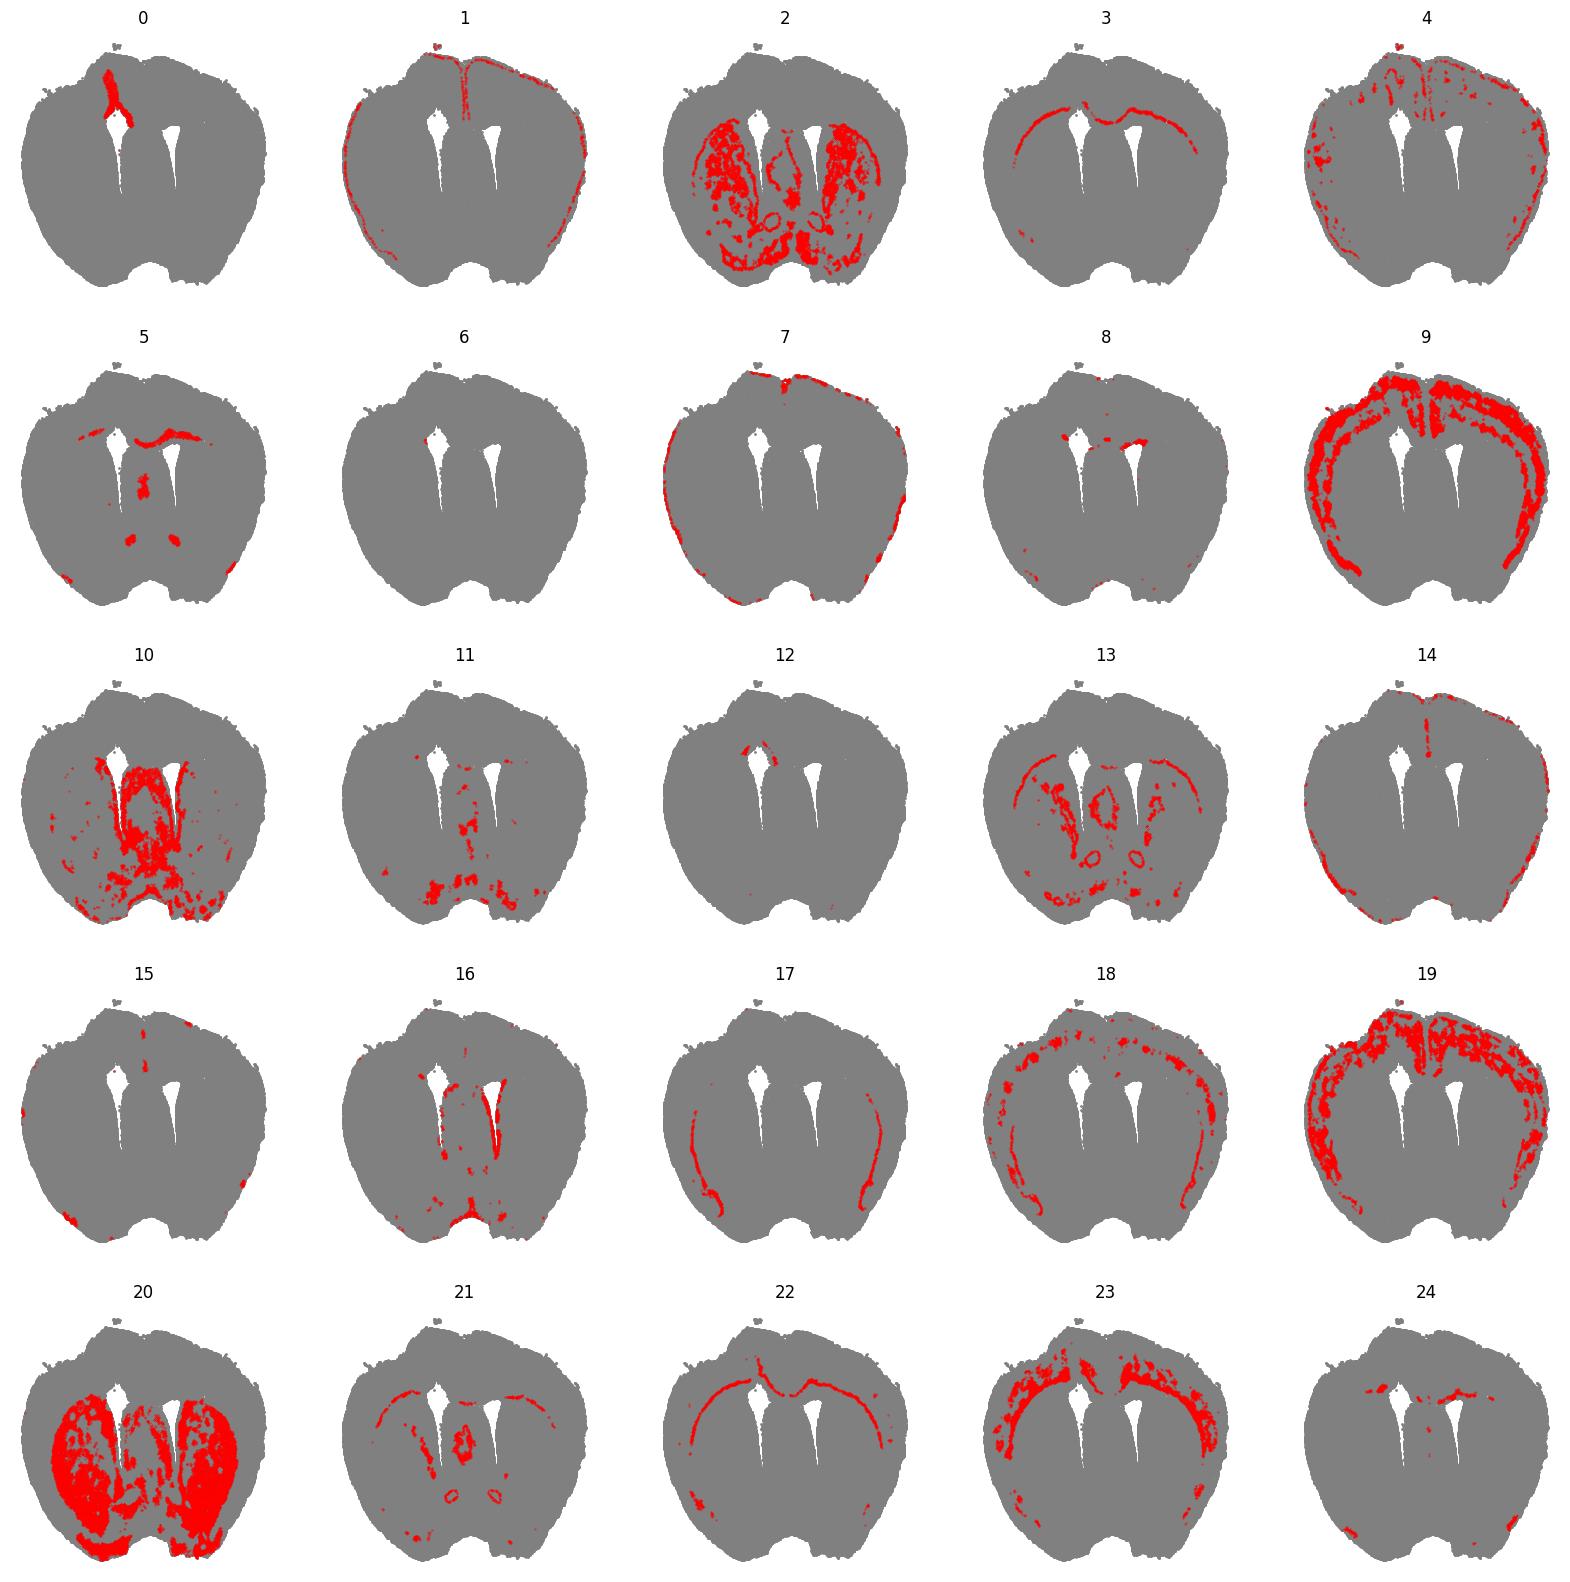

3.5


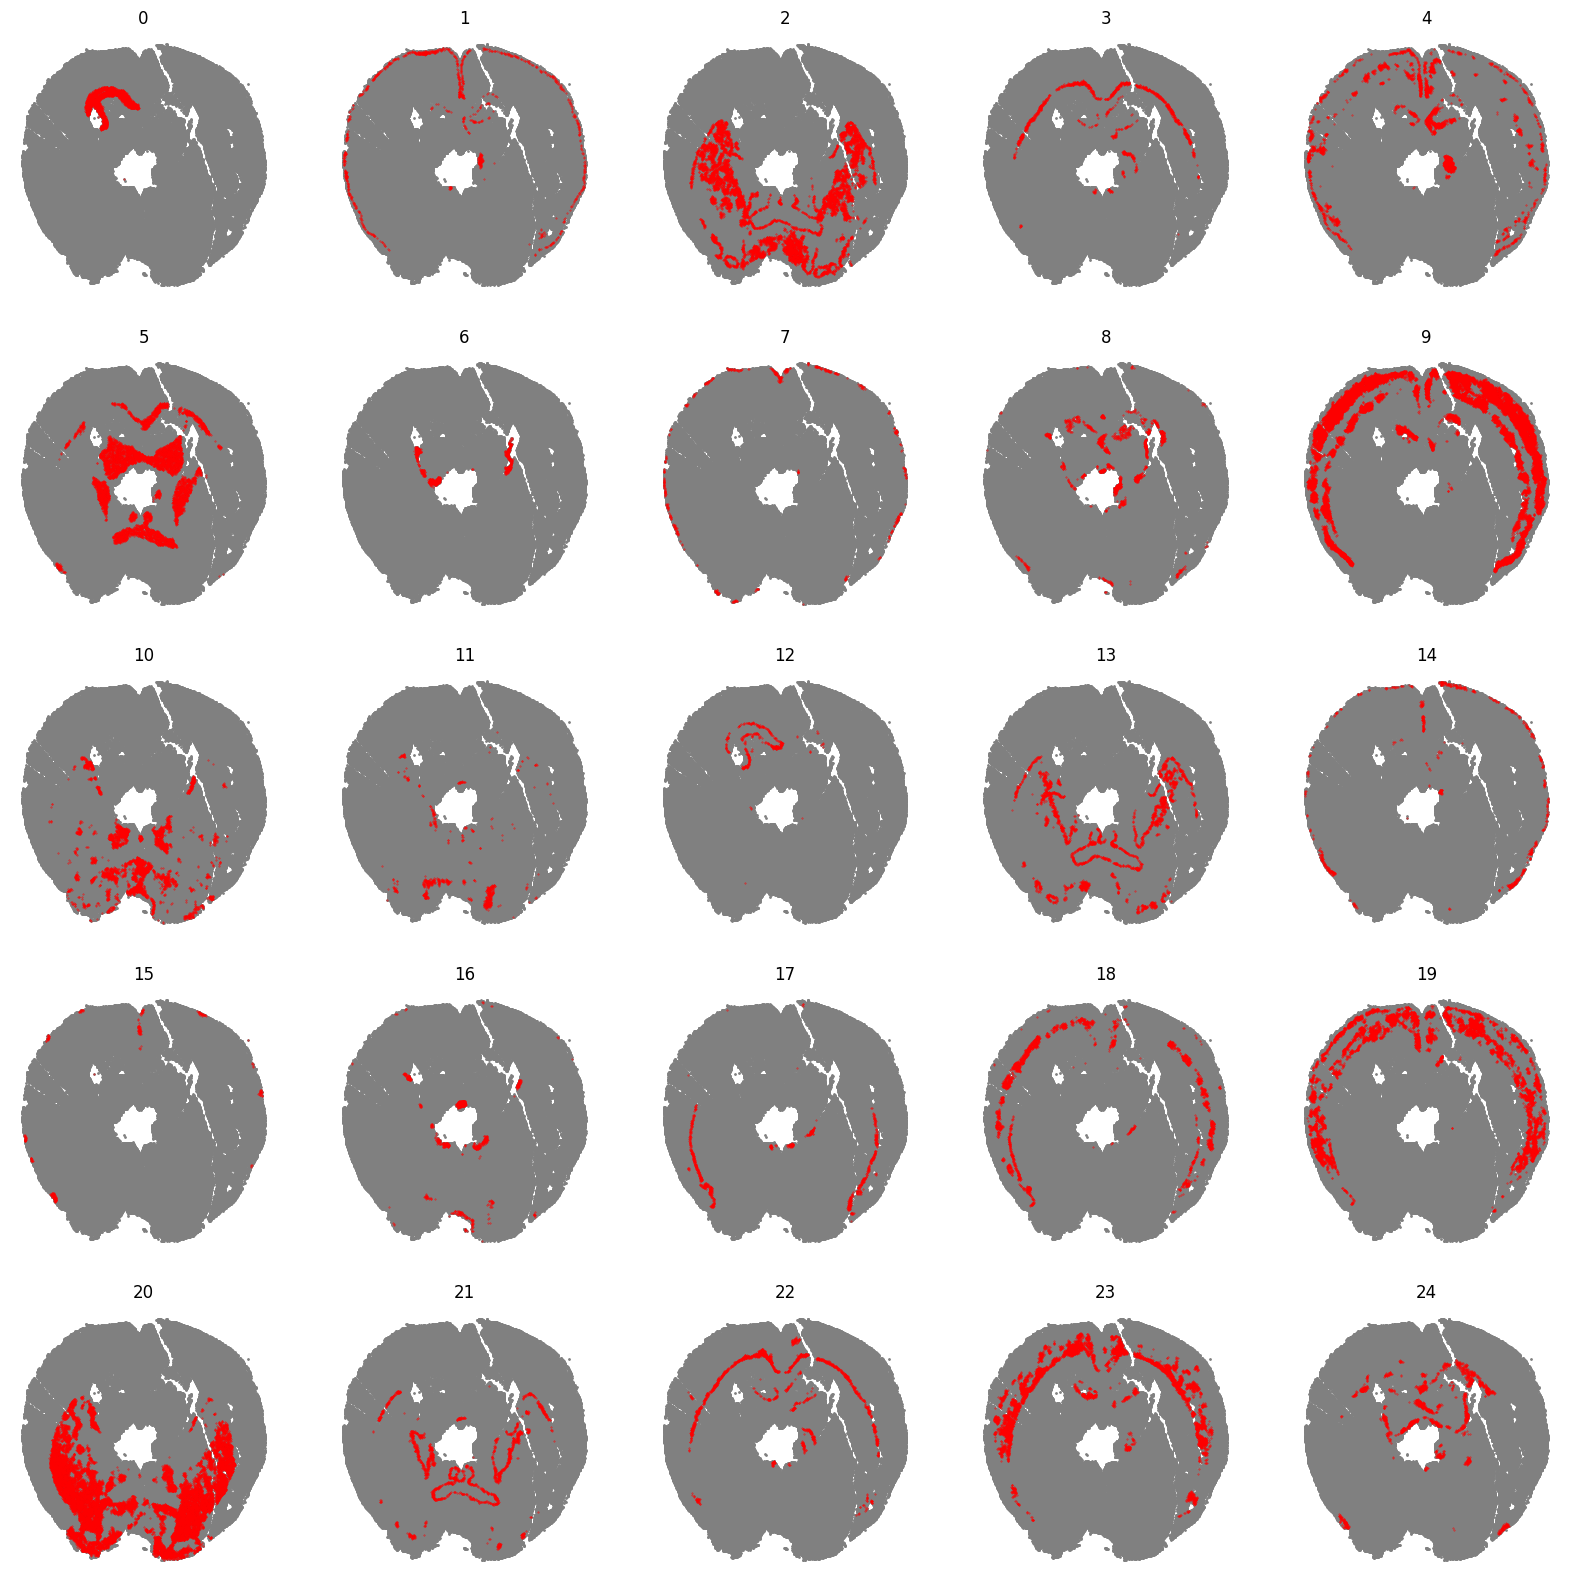

3.5


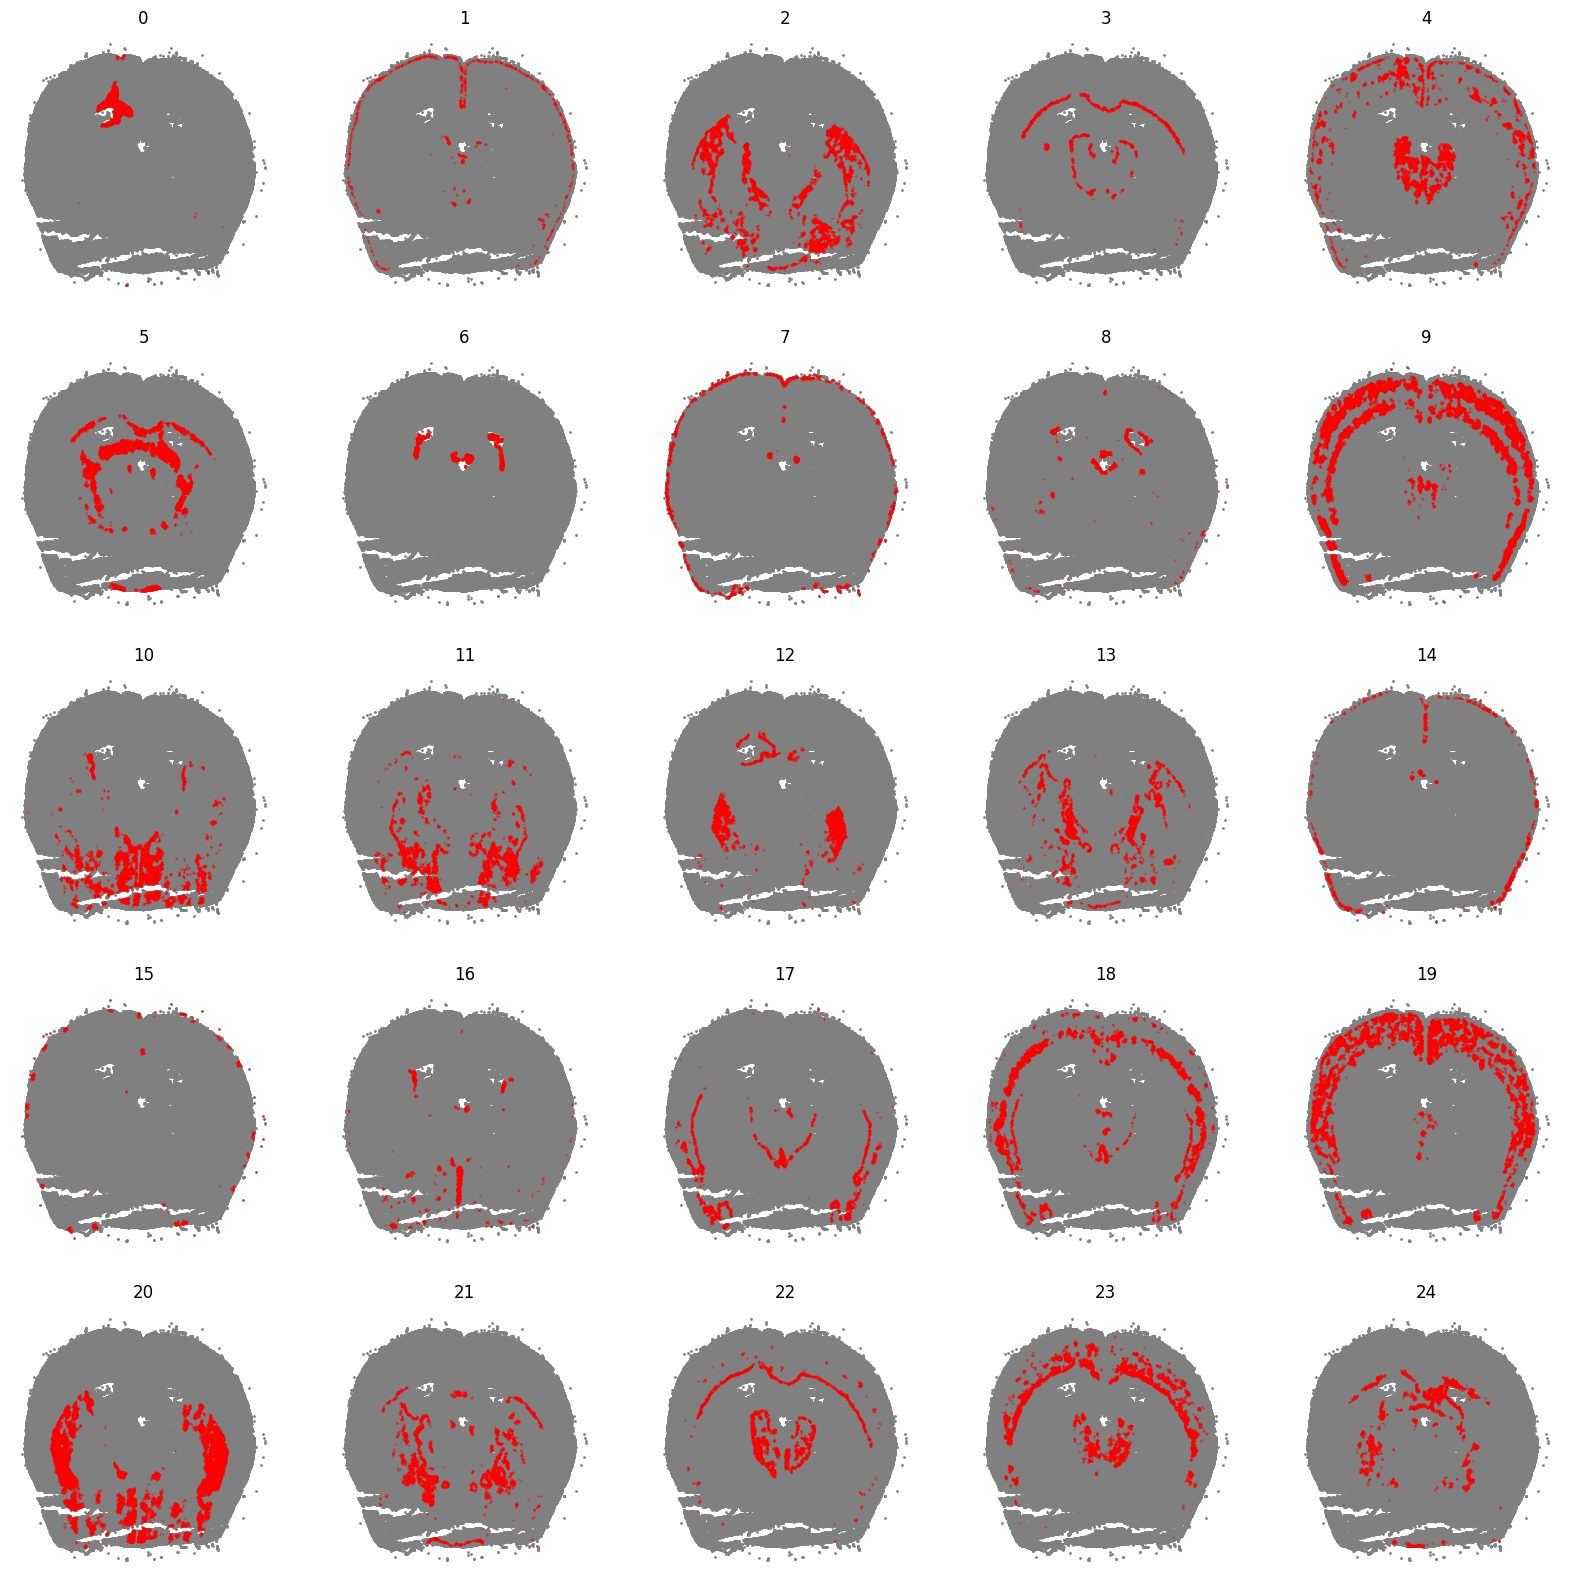

In [6]:
# Plot clusters

example_ids = np.unique(adata.obs.mouse_id)#["OT902", "YC1990", "OC1083"]

for example in example_ids:
    curr_adata = adata[adata.obs.mouse_id==example].copy()
    print(curr_adata.obs.age[0])
    
    plt.figure(figsize=(20,20))
    for i in range(curr_adata.obs.kmeans.max()+1):
        ax = plt.subplot(5,5,i+1)
        plot_clust(curr_adata,i,ax,key='kmeans')
    plt.show()

In [7]:
# manual region annotations

spatial_clust_annots_coarser = {
    0: 'Injury',
 1: 'CTX_L1/MEN',
 2: 'STR_CP/ACB',
 3: 'CC/ACO',
 4: 'CTX_L1/MEN',
 5: 'CC/ACO',
 6: 'VEN',
 7: 'CTX_L1/MEN',
 8: 'VEN',
 9: 'CTX_L2/3',
 10: 'STR_CP/ACB',
 11: 'STR_LS/NDB',
 12: 'CC/ACO', 
 13: 'STR_CP/ACB',
 14: 'CTX_L1/MEN',
 15: 'CTX_L1/MEN',
 16: 'VEN',
 17: 'STR_CP/ACB',
 18: 'CTX_L4/5/6',
 19: 'CTX_L2/3',
 20: 'STR_CP/ACB',
 21: 'STR_CP/ACB',
 22: 'CTX_L4/5/6',
 23: 'CTX_L4/5/6',
 24: 'VEN',
}

In [8]:
# map annotations 

adata.obs['region'] = [spatial_clust_annots_coarser[i] for i in adata.obs.kmeans]

In [9]:
# save regioned dataset

adata.write_h5ad(f"{fn}.h5ad")